In [1]:
# -*- coding: utf-8 -*-
# =============================================================================
# PHẦN 1: KHUNG CHƯƠNG TRÌNH - CÁC HÀM TÁI SỬ DỤNG
# Phiên bản này được cập nhật để chạy thử nghiệm hàng loạt với nhiều giá trị n.
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# -----------------------------------------------------------------------------
# 1.1. CÁC THUẬT TOÁN
# -----------------------------------------------------------------------------
def algorithm_1_basic_projection(F, P_K, x0, tau, max_iter=2000, tol=1e-7, verbose=True):
    """Thực hiện Thuật toán 1: Chiếu cơ bản."""
    x = np.copy(x0)
    start_time = time.time()
    iterations = 0

    for k in range(max_iter):
        iterations += 1
        x_next = P_K(x - tau * F(x))
        error = np.linalg.norm(x_next - x)
        if error < tol:
            break
        x = x_next

    final_error = np.linalg.norm(P_K(x - F(x)) - x)
    end_time = time.time()
    if verbose and error >= tol: print(f"  Cảnh báo: Thuật toán 1 không hội tụ sau {max_iter} vòng lặp.")
    return {
        "converged": error < tol, "solution": x, "time": end_time - start_time,
        "iterations": iterations, "final_error": final_error
    }

def algorithm_2_variable_step(F, P_K, x0, tau, max_iter=2000, tol=1e-7, verbose=True):
    """Thực hiện Thuật toán 2."""
    return algorithm_1_basic_projection(F, P_K, x0, tau, max_iter, tol, verbose)

# -----------------------------------------------------------------------------
# 1.2. HÀM TẠO BÀI TOÁN (Ví dụ Sun [18])
# -----------------------------------------------------------------------------
def create_sun_problem_instance(n):
    """Hàm tạo ra bài toán của Sun [18] với số chiều n."""
    M = np.diag(np.full(n, 4)) + np.diag(np.full(n-1, -1), 1) + np.diag(np.full(n-1, -1), -1)
    q = -np.ones(n)
    low_bounds = np.zeros(n)
    up_bounds = np.ones(n)
    x0 = np.zeros(n)
    def F(x): return M @ x + q
    def P_K(x): return np.clip(x, low_bounds, up_bounds)
    return {"name": f"Sun [18] (n={n})", "n": n, "F": F, "P_K": P_K, "x0": x0, "M": M}

# -----------------------------------------------------------------------------
# 1.3. HÀM XỬ LÝ CHÍNH - CHẠY HÀNG LOẠT
# -----------------------------------------------------------------------------

def run_batch_experiments(problem_generator, n_values):
    """
    Hàm chính để chạy thử nghiệm hàng loạt với nhiều giá trị n.
    - problem_generator: Một hàm (như create_sun_problem_instance) nhận n và trả về một bài toán.
    - n_values: Một danh sách các số chiều để thử nghiệm, ví dụ [10, 50, 100].
    """
    all_results = []

    print("="*80)
    print(f"BẮT ĐẦU CHẠY THỬ NGHIỆM HÀNG LOẠT CHO: {problem_generator.__name__}")
    print(f"Các giá trị n sẽ được kiểm tra: {n_values}")
    print("="*80)

    for n in n_values:
        print(f"\n--- Đang xử lý n = {n} ---")
        problem = problem_generator(n)
        M, F, P_K, x0 = problem["M"], problem["F"], problem["P_K"], problem["x0"]

        # Phân tích bài toán
        eigenvalues = np.linalg.eigvalsh(M)
        alpha = np.min(eigenvalues)
        L = np.max(eigenvalues)

        # Kiểm tra điều kiện và chọn tau
        tau_alg1, tau_alg2 = None, None

        # Alg 1: Dựa trên tính đơn điệu mạnh
        if alpha > 0:
            cond_alg1_upper = 2 * alpha / (L**2)
            tau_alg1 = cond_alg1_upper * 0.98

        # Alg 2: Dựa trên tính đồng bức
        # Với M xác định dương, F là (alpha/L^2)-đồng bức.
        # Với M nửa xđ dương, F là (1/L)-đồng bức.
        c = alpha / (L**2) if alpha > 0 else (1/L if L > 0 else 0)
        if c > 0:
            cond_alg2_upper = 2 * c
            tau_alg2 = cond_alg2_upper * 0.98

        # Chạy Thuật toán 1
        if tau_alg1 is not None:
            print(f"  Chạy Thuật toán 1 với τ = {tau_alg1:.4f}...")
            res1 = algorithm_1_basic_projection(F, P_K, x0, tau_alg1, verbose=False)
            all_results.append([f"n = {n}", "Alg. 1", res1["iterations"], f"{res1['time']:.5f}", f"{res1['final_error']:.2e}"])
        else:
            all_results.append([f"n = {n}", "Alg. 1", "N/A", "N/A", "N/A"])

        # Chạy Thuật toán 2
        if tau_alg2 is not None:
            print(f"  Chạy Thuật toán 2 với τ = {tau_alg2:.4f}...")
            res2 = algorithm_2_variable_step(F, P_K, x0, tau_alg2, verbose=False)
            all_results.append([f"n = {n}", "Alg. 2", res2["iterations"], f"{res2['time']:.5f}", f"{res2['final_error']:.2e}"])
        else:
            all_results.append([f"n = {n}", "Alg. 2", "N/A", "N/A", "N/A"])

    # Hiển thị bảng kết quả tổng hợp
    df = pd.DataFrame(all_results, columns=[
        "Problem", "Algorithm", "Iterations", "CPU Time (s)", "Final Error"
    ])

    # Định dạng bảng để dễ đọc hơn
    df_pivot = df.pivot(index='Problem', columns='Algorithm', values=['Iterations', 'CPU Time (s)'])
    # Sắp xếp lại thứ tự cột
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns, key=lambda x: (x[1], x[0])), axis=1)
    # Sắp xếp lại thứ tự hàng (index) theo n
    df_pivot = df_pivot.reindex(index=sorted(df_pivot.index, key=lambda x: int(x.split('=')[1][:-1])))


    print("\n\n" + "="*80)
    print("BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM")
    print("="*80)
    print(df_pivot)
    print("\n" + "="*80)

    return df

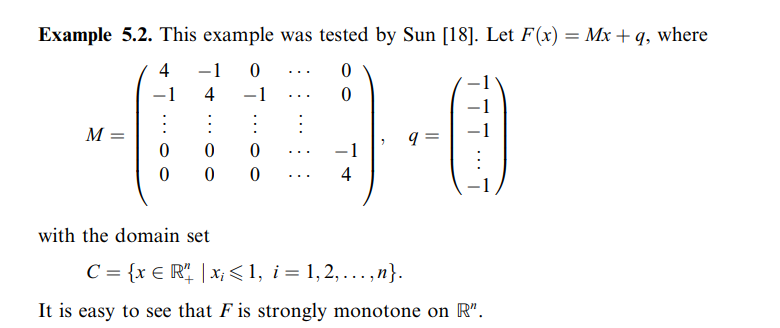

BẮT ĐẦU CHẠY THỬ NGHIỆM HÀNG LOẠT CHO: create_sun_problem_instance
Các giá trị n sẽ được kiểm tra: [10, 20, 50, 100, 200, 500]

--- Đang xử lý n = 10 ---
  Chạy Thuật toán 1 với τ = 0.1164...
  Chạy Thuật toán 2 với τ = 0.1164...

--- Đang xử lý n = 20 ---
  Chạy Thuật toán 1 với τ = 0.1109...
  Chạy Thuật toán 2 với τ = 0.1109...

--- Đang xử lý n = 50 ---
  Chạy Thuật toán 1 với τ = 0.1092...
  Chạy Thuật toán 2 với τ = 0.1092...

--- Đang xử lý n = 100 ---
  Chạy Thuật toán 1 với τ = 0.1090...
  Chạy Thuật toán 2 với τ = 0.1090...

--- Đang xử lý n = 200 ---
  Chạy Thuật toán 1 với τ = 0.1089...
  Chạy Thuật toán 2 với τ = 0.1089...

--- Đang xử lý n = 500 ---
  Chạy Thuật toán 1 với τ = 0.1089...
  Chạy Thuật toán 2 với τ = 0.1089...


BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM
          CPU Time (s) Iterations CPU Time (s) Iterations
Algorithm       Alg. 1     Alg. 1       Alg. 2     Alg. 2
Problem                                                  
n = 10         0.00214         56      0.0

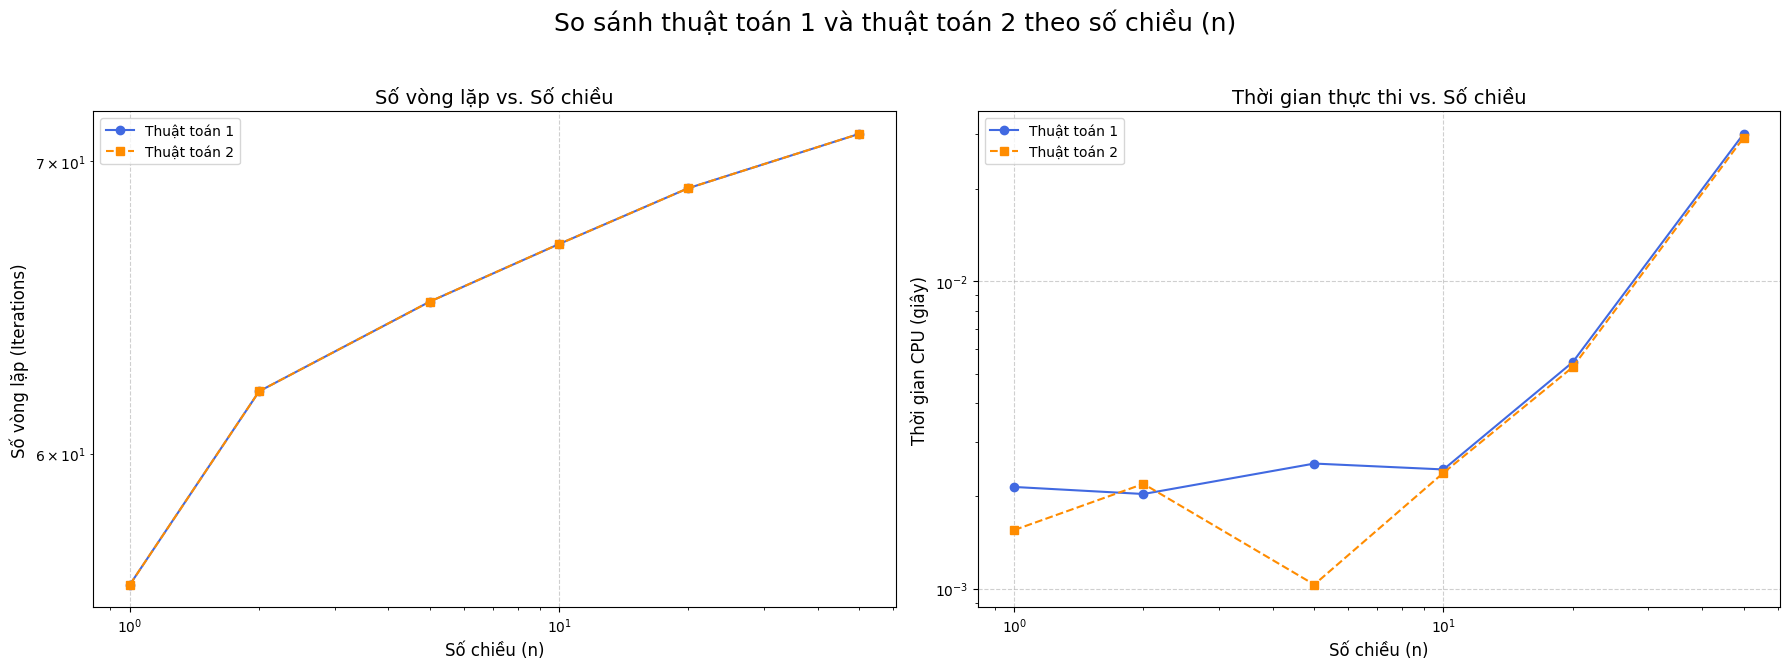

In [2]:
# =============================================================================
# PHẦN 2: CHẠY THỬ NGHIỆM VÀ VẼ BIỂU ĐỒ
# =============================================================================

# Danh sách các giá trị n bạn muốn kiểm tra
n_values_to_test = [10, 20, 50, 100, 200, 500]

# Chạy thử nghiệm hàng loạt
results_df = run_batch_experiments(create_sun_problem_instance, n_values_to_test)

# --- Trực quan hóa kết quả ---
# Lấy dữ liệu từ DataFrame để vẽ
n_labels = [int(p.split('=')[1][:-1]) for p in results_df['Problem'].unique()]
iterations_alg1 = results_df[results_df['Algorithm'] == 'Alg. 1']['Iterations'].tolist()
iterations_alg2 = results_df[results_df['Algorithm'] == 'Alg. 2']['Iterations'].tolist()
time_alg1 = [float(t) for t in results_df[results_df['Algorithm'] == 'Alg. 1']['CPU Time (s)'].tolist()]
time_alg2 = [float(t) for t in results_df[results_df['Algorithm'] == 'Alg. 2']['CPU Time (s)'].tolist()]

# Tạo biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle("So sánh thuật toán 1 và thuật toán 2 theo số chiều (n)", fontsize=18)

# Biểu đồ 1: Số vòng lặp
ax1.plot(n_labels, iterations_alg1, 'o-', label='Thuật toán 1', color='royalblue')
ax1.plot(n_labels, iterations_alg2, 's--', label='Thuật toán 2', color='darkorange')
ax1.set_xlabel("Số chiều (n)", fontsize=12)
ax1.set_ylabel("Số vòng lặp (Iterations)", fontsize=12)
ax1.set_title("Số vòng lặp vs. Số chiều", fontsize=14)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xscale('log') # Thang log cho n để nhìn rõ hơn
ax1.set_yscale('log') # Thang log cho số vòng lặp

# Biểu đồ 2: Thời gian thực thi
ax2.plot(n_labels, time_alg1, 'o-', label='Thuật toán 1', color='royalblue')
ax2.plot(n_labels, time_alg2, 's--', label='Thuật toán 2', color='darkorange')
ax2.set_xlabel("Số chiều (n)", fontsize=12)
ax2.set_ylabel("Thời gian CPU (giây)", fontsize=12)
ax2.set_title("Thời gian thực thi vs. Số chiều", fontsize=14)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xscale('log') # Thang log
ax2.set_yscale('log') # Thang log

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()